</br>
<img src="figures/header.png">

## A fruit-basket example

Coming out of academia, I'm currently learning to convince myself and others, that what I did in the past years is also valuable, interesting and practically relevant (read: marketable 🤑) in the "real" world. 
So, without loss of generality, let's imagine this simplistic yet ubiquitous business example^[Note that, while I give this a business spin, the same concepts apply in *research* questions: Whenever an intervention is tested against a control, the goal is to robustly assess if the intervention works]:

You're running a fruit-basket delivery business with a website where people can sign up for your delivery service. Things are going well, but you get an email from an overeducated yet unknown behavioral scientist who saw your page and berates you on how much better your business would be doing, if only you knew something about how people allocate their attention and how it influences their decision-making.

Now, you believe in science, so you agree to pay the scientist a decent amount of money to receive those precious *actionable insights*✨ and improve your landing page. While your cognitive dissonance tries its hardest to convince you of how well the money was spent, you also paid a lot for your MBA, so you plan to run a proper experiment of the new design's effectiveness. 

### The frequentist approach

Given a setup like this, a basic frequentist approach would require you to

1. Plan your sample size upfront, given an expected minimum effect size
2. Collect all data without peeking
3. Make a single yes/no decision based on whether p < 0.05. 

This works, but it does feel a bit rigid^[and often comes with some [difficulties in interpretations](https://journals.plos.org/mentalhealth/article?id=10.1371/journal.pmen.0000242)]: What if someone wants to have intermediate results? You're not allowed to peek, because that would [inflate your rate of false positives](https://dl.acm.org/doi/abs/10.1145/3097983.3097992). What if someone asks "how likely is it that the new design is actually better?" The p-value doesn't answer that. What if you want to quantify the cost of making the wrong decision? Frequentist methods don't naturally speak that language.

### A Bayesian alternative

Here, I want to demonstrate how Bayesian analysis offers a different perspective on these types of issues and how it provides more intuitive and directly actionable✨ metrics.
Notably, these metrics can be computed at any time as data comes in, giving you a rich picture of your experiment's status.

::: {.callout-note collapse="false"}
## A note on "early stopping"
You may have heard that Bayesian methods let you "peek without penalty" and stop experiments early. This is **partially true but misleading**. While Bayesian metrics remain valid interpretations of your current data at any point, using them naively as stopping rules can also inflate false positive rates just like peeking does in frequentist testing. Check out [this simulation](http://varianceexplained.org/r/bayesian-ab-testing/). 
:::

## Frequentist baseline

For reference, however, let's start with the basic frequentist approach:

### Power analysis

First, let's determine the required sample size using traditional methods. The first variable we need to decide on is the effect size we want to be able to detect. Let's assume, our current data shows that your website has a sign-up rate of 10%. You expect the new design to improve this by 20% ("relative lift") to 12%, so we're looking to detect a 2 percentage point effect.  
Next, we need to determine the test's power, that is, the probability to find the effect, if the effect was real. In this case, we'd really hate to miss out on this opportunity of an improved website, so we'll set a high power of 80%.  
Finally, we need to define a false-positive rate that we're okay with. We'll stick to the regular α = 0.05, meaning that in 5% of studies like this, we'll conclude that there is an effect, even though there was just noise.

We'll use the `frequentist.power_analysis` function from the `bayesian_ab` package that accompanies this post.

In [ ]:
# Import bayesian_ab and other necessary packages
import numpy as np
import pandas as pd

import src.bayesian_ab as bab

In [ ]:
# True rates
true_p_control = 0.10  # we have this from our pre-experiment data
relative_lift = 0.2  # minimum detectable effect in relative terms

# Run power analysis
# this function wraps statsmodels.stats.power.zt_ind_solve_power
power_result = bab.frequentist.power_analysis(
    p_control=true_p_control,
    relative_lift=relative_lift,
    power=0.80,
    alpha=0.05,
    alternative="larger",
)
print(power_result)

PowerAnalysisResult(n_per_group=3021, 
total_n=6042, effect_size=0.0640, 
power=0.80, alpha=0.05, 
p_control=0.1000, p_treatment=0.1200, 
relative_lift=0.2000)


Now we have a total sample size and given our daily number of visitors, we can compute how long this experiment would take to run:

In [ ]:
daily_n_per_group = 200  # half our daily visitors
n_days = int(np.ceil(power_result.n_per_group / daily_n_per_group))
n_days
print(f"The experiment needs to run for {n_days} days.")

The experiment needs to run for 16 days.


### Collect data

Next, we'd run our experiment. Here, we'll simulate data instead, but make it look like it came in day by day, as it would in reality. We're using `bab.simulation.simulate_ab_test`:

In [ ]:
# Simulate daily data
true_p_treatment = true_p_control * (1 + relative_lift)
data = bab.simulation.simulate_ab_test(
    n_days=n_days,
    daily_n=daily_n_per_group,
    p_a=true_p_control,
    p_b=true_p_treatment,
    seed=10439,
)

In [ ]:
# | code-fold: true
# | code-summary: Add some useful variables
from statsmodels.stats.proportion import proportion_confint

# Add descriptive labels
data["design"] = data["variant"].map({"A": "Control", "B": "New Design"})
data["signups"] = data["conversions"]
data["visitors"] = data["n"]

# Add cumulative metrics
data["n_cum"] = data.groupby("variant")["n"].cumsum()
data["conversions_cum"] = data.groupby("variant")["conversions"].cumsum()

# Add confidence intervals for cumulative counts
ci = proportion_confint(
    count=data["conversions_cum"], nobs=data["n_cum"], method="wilson", alpha=0.05
)
data["ci_lower"] = ci[0]
data["ci_upper"] = ci[1]

# Print overview
data[["day", "design", "visitors", "signups"]].set_index(["day", "design"]).head(4)

visitors  signups
day design                       
1   Control          200       24
    New Design       200       20
2   Control          200       18
    New Design       200       19

### Visualize data

Let's see what our data look like:

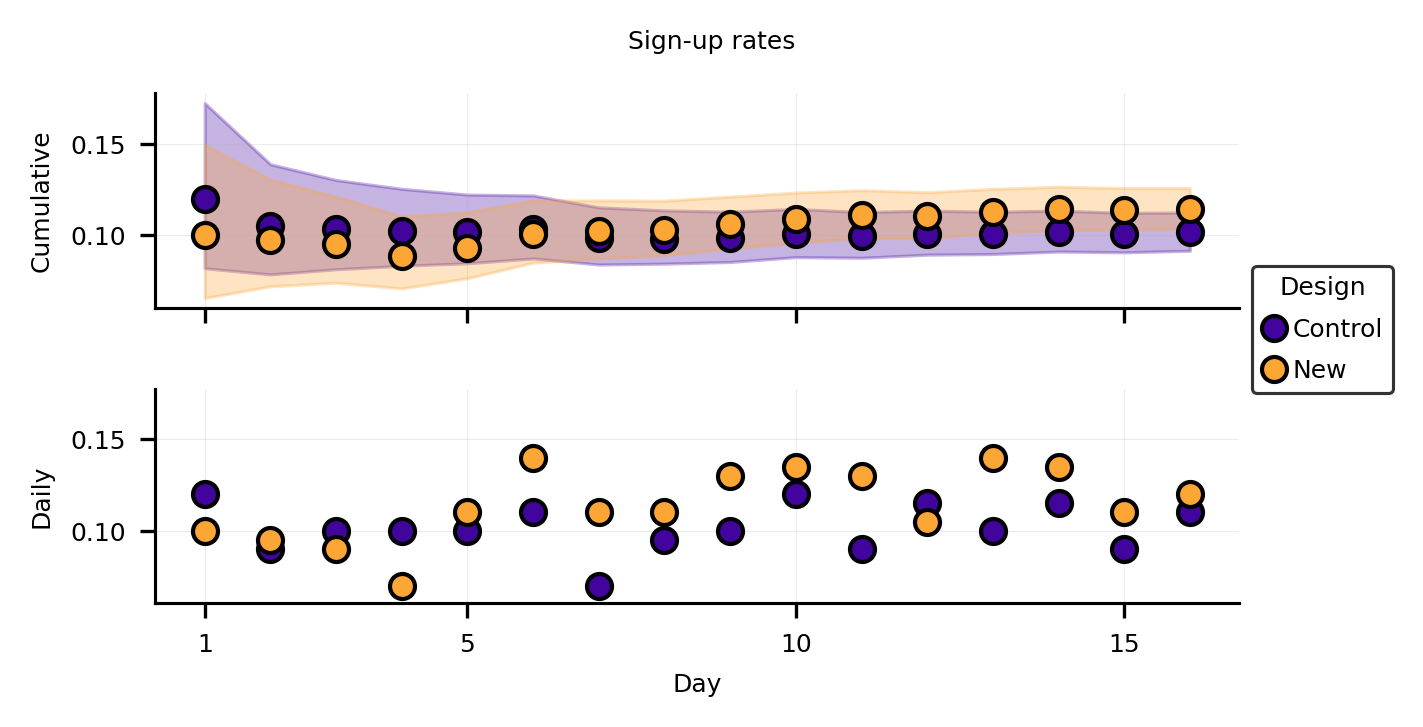

In [ ]:
# | label: fig-data
# | fig-cap: "Experiment data. The top panel shows sign-up rate data over the cumulative data. The bottom panel shows the sign-up rates for each day."
# | code-fold: true
# | code-summary: Show plotting function

import matplotlib.pyplot as plt
import myplotlib as my

colors = {variant: plt.cm.plasma(c) for variant, c in zip(["A", "B"], [0.1, 0.8])}
labels = {"A": "Control", "B": "New"}

fig, axs = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=my.utilities.cm2inch(12, 6)
)


for v in ["A", "B"]:
    data_v = data.query("variant == @v")

    # Top: Daily cumulative proportion
    axs[0].plot(
        data_v["day"],
        data_v["conversions_cum"] / data_v["n_cum"],
        "o",
        clip_on=False,
        label=labels[v],
        color=colors[v],
    )
    axs[0].fill_between(
        data_v["day"],
        data_v["ci_lower"],
        data_v["ci_upper"],
        alpha=0.3,
        zorder=-1,
        color=colors[v],
    )

    # Bottom: Daily proportion
    axs[1].plot(
        data_v["day"],
        data_v["conversions"] / data_v["n"],
        "o",
        clip_on=False,
        color=colors[v],
    )

# Labels
fig.suptitle("Sign-up rates")
axs[0].set_ylabel("Cumulative")
axs[1].set_ylabel("Daily")
axs[1].set_xlabel("Day")

# Ticks and Limits
axs[1].set_xticks([1, 5, 10, 15])
for ax in axs:
    ax.grid(alpha=0.25, lw=0.25, fillstyle="top")
# Legend
axs[0].legend(bbox_to_anchor=(1, -0.1), loc="center left", title="Design")
# Layout
fig.tight_layout(h_pad=-0.3)
fig.align_ylabels()

Imagine seeing this data as it came in. On day one, you're really optimistic and can't wait to see how well the new landing page will perform. Think of all the fruit you will sell! At the end of the day, however, you mainly feel regret: The new design performed *worse* than your old trusted one. The new one doesn't even do any better than your historical average of 10%. You think about calling off the whole thing and asking for a refund, but then notice the huge error bars on those numbers (@fig-data; top panel) and decide to do the "right thing" and let the experiment run its course.  

In the next few days, however, your hopes for a bright fruit-selling future are crushed even more. While the old design doesn't perform as well as on day one anymore, the new design keeps on tanking more. You call your data scientist who runs the study, but they've called in sick (because they too saw the data coming in...). You have no chance but to let the experiment roll.  

And what a twist. Starting from day five, the new design (almost) consistently outperforms the old one and the long term sign-up rates (@fig-data; top panel) indicate a solid 2 percentage point increase.

### Run the test

After data are collected, the next step is to run our test. In this case, we're running a [$z$-test](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) on two the proportions. We're using `bab.frequentist.proportion_test`, which wraps the corresponding `statsmodels` function:

In [ ]:
# Run traditional frequentist test (wraps statsmodels.stats.proportion.proportions_ztest)
freq_result = bab.frequentist.proportion_test(data, alpha=0.05, alternative="larger")
freq_result

ProportionTestResult(z_statistic=1.6514, 
p_value=0.0493, significant=True, 
alpha=0.05, rate_a=0.1016, 
rate_b=0.1144, absolute_lift=0.0128, 
relative_lift=0.1262, ci_a=(0.0910964277480344, 0.1120285722519656), 
ci_b=(0.10334784220593264, 0.12540215779406738), n_a=3200, n_b=3200, 
alternative='larger')

Hallelujah, what a ride! The $p$-value is below the magical limit of 0.05. The effect is significant💞. Life is good. Science works, you get to use the new design and are happy to live in a better world that is richer in fruit-baskets.

## The Bayesian approach

I want to present an alternative approach that provides more intuitive and directly actionable metrics: the Bayesian way.

### The core idea

Bayesian statistics uses probability distributions to describe uncertainty about parameters. We start with a **prior** distribution (what we believe before seeing data), observe data, and update to a **posterior** distribution (what we believe after seeing data). This updating happens via Bayes' theorem, weighting the prior by the **likelihood** of the observed data. Basically, it's logic but for probability.

For our example, the natural choice of probability distributions is given in the **Beta-Binomial** model. We model sign-ups as Bernoulli trials (each visitor either signs up or doesn't), and we use the Beta distribution to describe our uncertainty about the true sign-up rate $p$.

The Beta distribution has two parameters, $\alpha$ and $\beta$, which you can think of as "pseudo-counts" of successes and failures. A $\text{Beta}(1, 1)$ is uniform—we're saying any sign-up rate from 0% to 100% is equally plausible. As we observe data, we simply add our observed successes and failures:

$$\text{Posterior} = \text{Beta}(\alpha + \text{sign-ups}, \beta + \text{non-sign-ups})$$

Let's visualize how this works. Imagine we're tracking just the new design, starting with a uniform prior:

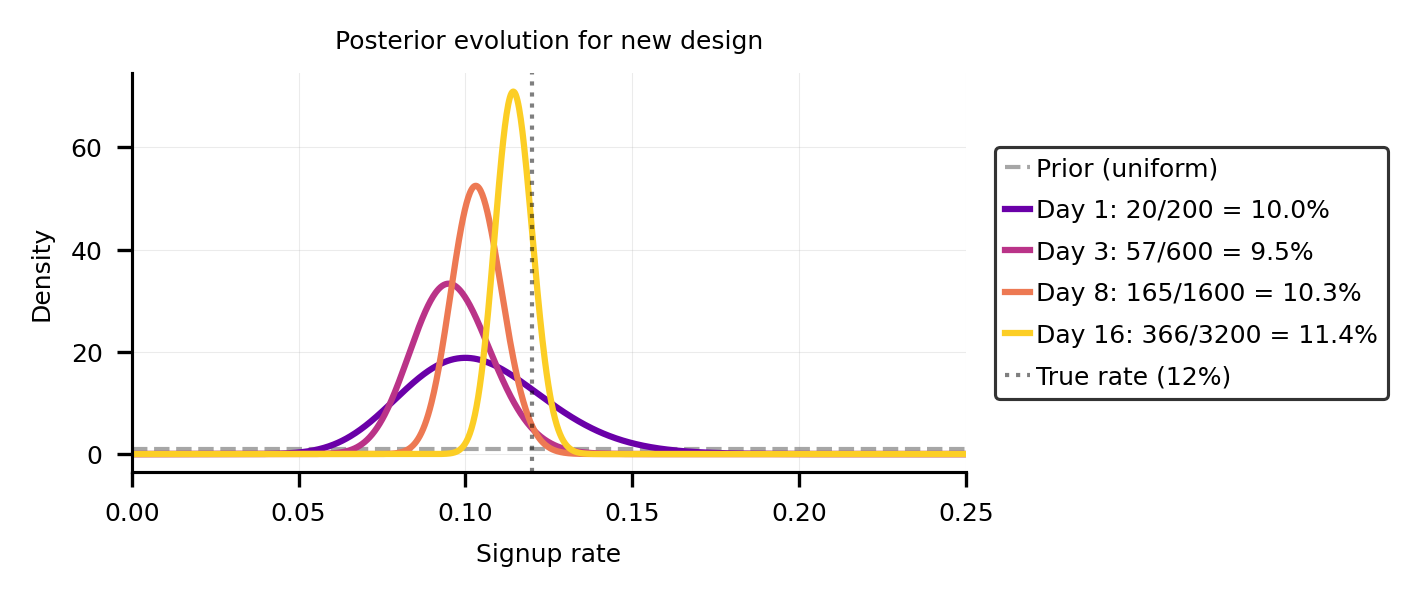

In [ ]:
# | code-fold: true
# | code-summary: Show code
# | label: fig-posterior-evolution
# | fig-cap: "Posterior evolution for the new design. Starting from a uniform prior (dashed), the posterior narrows and centers around the true sign-up rate as data accumulates."

import scipy.stats as stats

fig, ax = plt.subplots(figsize=my.utilities.cm2inch(12, 5))

x = np.linspace(0, 0.25, 1000)

# Prior
prior = stats.beta(1, 1)
ax.plot(x, prior.pdf(x), "--", color="gray", label="Prior (uniform)", alpha=0.7)

# Show posterior evolution for new design only
cols = plt.cm.plasma(np.linspace(0.2, 0.9, 4))
for i, day in enumerate([1, 3, 8, n_days]):
    data_day = data.query("day == @day & variant == 'B'")
    conv = data_day["conversions_cum"].values[0]
    n = data_day["n_cum"].values[0]

    posterior = stats.beta(1 + conv, 1 + n - conv)
    ax.plot(
        x,
        posterior.pdf(x),
        color=cols[i],
        label=f"Day {day}: {conv}/{n} = {conv/n:.1%}",
        lw=1.5,
    )

ax.axvline(
    true_p_treatment,
    color="black",
    linestyle=":",
    alpha=0.5,
    label=f"True rate ({true_p_treatment:.0%})",
)
ax.set_xlabel("Signup rate")
ax.set_ylabel("Density")
ax.set_title("Posterior evolution for new design")
ax.legend(bbox_to_anchor=(1.02, 0.5), loc="center left")
ax.set_xlim(0, 0.25)
ax.grid(alpha=0.25, lw=0.25, fillstyle="top")
fig.tight_layout()

Notice how the distribution starts flat (uniform prior; any rate is possible), then quickly concentrates around the observed rate as data accumulates. By day 16, we have a tight estimate centered near the true rate of 12%.

### Using informative priors

Here's where Bayesian methods offer a practical advantage: we can incorporate prior knowledge.

For the **control** group, we're not starting from scratch! This is your existing landing page! We likely have months of historical data (i.e., visits and sign-up numbers). If we've seen 1,000 visitors with 100 sign-ups historically, we can encode this as a $\text{Beta}(101, 901)$ prior. This prior is already concentrated around 10%, reflecting our confidence from past data.

For the **new design**, we genuinely don't know—so a weakly informative prior like $\text{Beta}(1, 1)$ (uniform) or $\text{Beta}(2, 18)$ (weakly centered on 10%) makes sense.

This asymmetry is realistic: we know more about the status quo than the challenger.

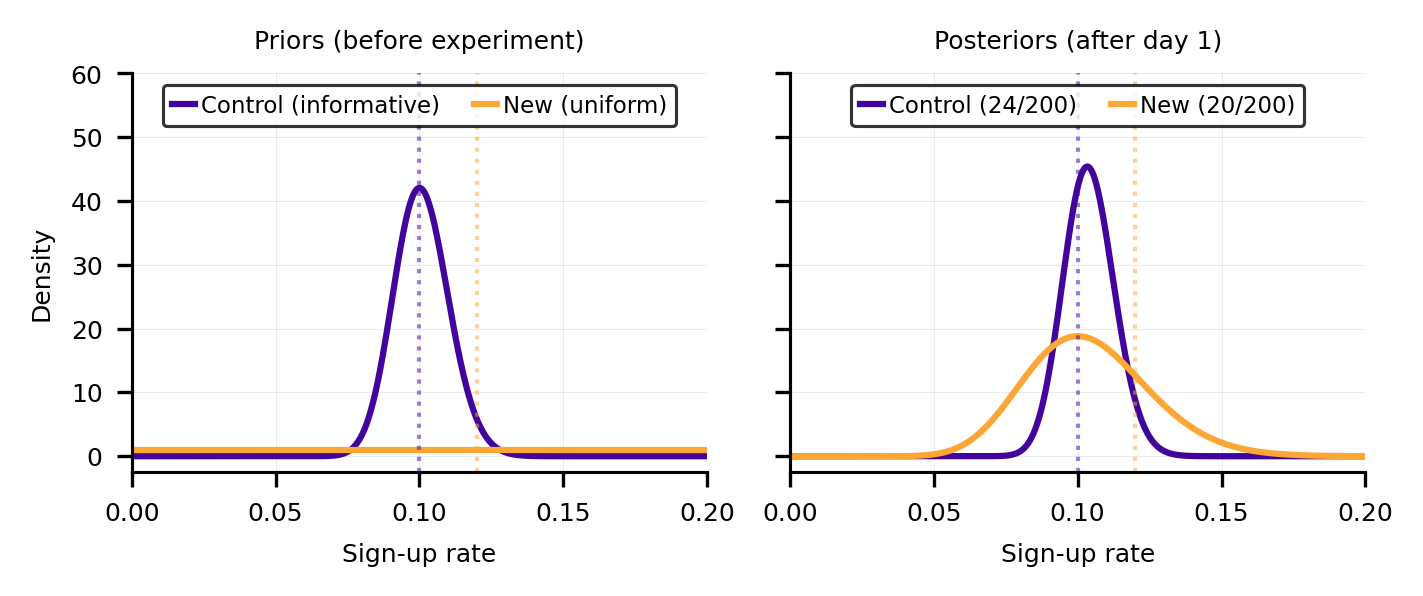

In [ ]:
# | code-fold: true
# | code-summary: Show code
# | label: fig-distributions
# | fig-cap: "Informative vs. uniform priors and their posteriors after day 1. The control prior reflects historical data and barely shifts, while the new design posterior concentrates quickly."

# Define priors
# Control: informative prior from historical data (e.g., 1000 signups out of 10000 visitors)
prior_control_alpha = 100 + 1  # historical signups + 1
prior_control_beta = 900 + 1  # historical non-signups + 1

# New design: weakly informative prior (we don't know much)
prior_new_alpha = 1
prior_new_beta = 1

fig, axs = plt.subplots(1, 2, figsize=my.utilities.cm2inch(12, 5), sharey=True)
x = np.linspace(0, 0.20, 1000)

# Left panel: Priors
ax = axs[0]
prior_control = stats.beta(prior_control_alpha, prior_control_beta)
prior_new = stats.beta(prior_new_alpha, prior_new_beta)

ax.plot(
    x, prior_control.pdf(x), color=colors["A"], label="Control (informative)", lw=1.5
)
ax.plot(x, prior_new.pdf(x), color=colors["B"], label="New (uniform)", lw=1.5)
ax.axvline(true_p_control, color=colors["A"], linestyle=":", alpha=0.5)
ax.axvline(true_p_treatment, color=colors["B"], linestyle=":", alpha=0.5)
ax.set_xlabel("Sign-up rate")
ax.set_ylabel("Density")
ax.set_title("Priors (before experiment)")
ax.legend(loc="upper center", ncol=2, fontsize=5.5)
ax.set_xlim(0, 0.20)
ax.grid(alpha=0.25, lw=0.25, fillstyle="top")

# Right panel: Posteriors after day 1
ax = axs[1]
data_day1 = data.query("day == 1")
conv_a = data_day1.query("variant == 'A'")["signups"].values[0]
n_a = data_day1.query("variant == 'A'")["n"].values[0]
conv_b = data_day1.query("variant == 'B'")["signups"].values[0]
n_b = data_day1.query("variant == 'B'")["n"].values[0]

post_control = stats.beta(
    prior_control_alpha + conv_a, prior_control_beta + n_a - conv_a
)
post_new = stats.beta(prior_new_alpha + conv_b, prior_new_beta + n_b - conv_b)

ax.plot(
    x, post_control.pdf(x), color=colors["A"], label=f"Control ({conv_a}/{n_a})", lw=1.5
)
ax.plot(x, post_new.pdf(x), color=colors["B"], label=f"New ({conv_b}/{n_b})", lw=1.5)
ax.axvline(true_p_control, color=colors["A"], linestyle=":", alpha=0.5)
ax.axvline(true_p_treatment, color=colors["B"], linestyle=":", alpha=0.5)
ax.set_xlabel("Sign-up rate")
ax.set_title("Posteriors (after day 1)")
ax.legend(loc="upper center", ncol=2, fontsize="5.5")
ax.set_xlim(0, 0.20)
ax.set_ylim(-2.5, 60)
ax.grid(alpha=0.25, lw=0.25, fillstyle="top")

fig.tight_layout()

The left panel of @fig-distributions shows our starting beliefs: we're confident the control is around 10% (narrow distribution), but have no idea about the new design (flat distribution). 

After just one day of data (@fig-distributions, right panel), something interesting happens: the control's posterior barely moves (the new data is a drop in the bucket compared to our historical knowledge), while the new design's posterior has already concentrated around its observed rate. The new design had a rough first day (10% vs the control's 12%), but we're still quite uncertain about its true rate.

This is a more honest representation of our actual knowledge state than treating both variants symmetrically with uniform priors.

### Metrics from probability distributions

What I really enjoy about the Bayesian framework is that we can take these probability distributions and derive many different metrics, each answering a distinct question that might matter for our decision. Let's look at three metrics with intuitive interpretations and practical implications.

#### P(B > A): Is the new design better?

The most direct question: what's the probability that the new design's true conversion rate is higher than the control's? 
We can compute this from our probability distributions: Imagine repeatedly drawing random samples^[We're using Monte Carlo sampling instead of analytical solutions. For the Beta-Binomial model, closed-form solutions exist, but sampling is more general: it works the same way for simple and complex models. In future posts, when we build more complex models with PyMC, sampling will be essential, as there are no (feasible) analytic solutions anymore.] from the "Control" and "New Variant" distributions (@fig-distributions). Then you compute $P(B > A)$ as the proportion of sample-pairs, where sample B was larger than sample A.

#### Region of practical equivalence (ROPE)

Sometimes "better" isn't good enough—we want to know if the improvement is *meaningful*. A ROPE analysis asks: What's the probability that the difference exceeds some practically relevant threshold? That it lies outside a "region of practical equivalence"?  
Again, this can be computed from our distributions: Sample from both distributions and compute differences. Then compute the proportion of differences outside (e.g., larger than) your ROPE. It's straightforward.

#### Expected loss: The decision-theoretic approach

Perhaps the most useful metric for business decisions is **expected loss** (or expected regret). This quantifies the opportunity cost of making a decision *right now*.

The idea, [formalized by Chris Stucchio for VWO](https://vwo.com/downloads/VWO_SmartStats_technical_whitepaper.pdf), is simple: If we choose the new design (B), but our old one (A) was actually better, we lose potential sign-ups. The expected loss is:

$$\mathbb{E}[\text{Loss}_B] = \mathbb{E}[\max(p_A - p_B, 0)]$$

In regular people language: sometimes A is better (we lose, proportional to how much better A is), sometimes B is better (we lose nothing). The expectation weights these scenarios by their current posterior probability.

This is a particularly interesting metric. While $P(B > A) = 95%$ tells you "B is probably better.", expected loss makes the trade-off of a potential decision more clear: "Even if I'm wrong about B, I only lose X% per visitor." I think some people would call that *actionable*✨. Compare it to your cost of running the experiment longer and make an informed decision.

### Tracking metrics over time

Now let's see how these metrics evolve as data comes in. This is where the Bayesian approach shines - we get a continuous, interpretable view of our experiment's status and can update and form beliefs, uncertainty, and best estimates:

In [ ]:
# Bayesian sequential updating: track metrics day by day

n_samples = 100_000  # for Monte Carlo estimation
results = []

rope_width = 0.005  # Define region of Practical Equivalence

for day in range(1, n_days + 1):
    # Get cumulative data up to this day
    data_day = data.query("day == @day")

    n_a = data_day.query("variant == 'A'")["n_cum"].values[0]
    n_b = data_day.query("variant == 'B'")["n_cum"].values[0]
    conv_a = data_day.query("variant == 'A'")["conversions_cum"].values[0]
    conv_b = data_day.query("variant == 'B'")["conversions_cum"].values[0]

    # Posterior distributions with informative prior for control
    post_a = stats.beta(prior_control_alpha + conv_a, prior_control_beta + n_a - conv_a)
    post_b = stats.beta(prior_new_alpha + conv_b, prior_new_beta + n_b - conv_b)

    # Sample from posteriors
    samples_a = post_a.rvs(n_samples)
    samples_b = post_b.rvs(n_samples)

    # Compute metrics
    prob_b_better = np.mean(samples_b > samples_a)
    expected_loss_b = np.mean(np.maximum(samples_a - samples_b, 0))
    prob_above_rope = np.mean((samples_b - samples_a) > rope_width)

    results.append(
        {
            "day": day,
            "prob_b_better": prob_b_better,
            "expected_loss_b": expected_loss_b,
            "prob_above_rope": prob_above_rope,
        }
    )

results_df = pd.DataFrame(results)

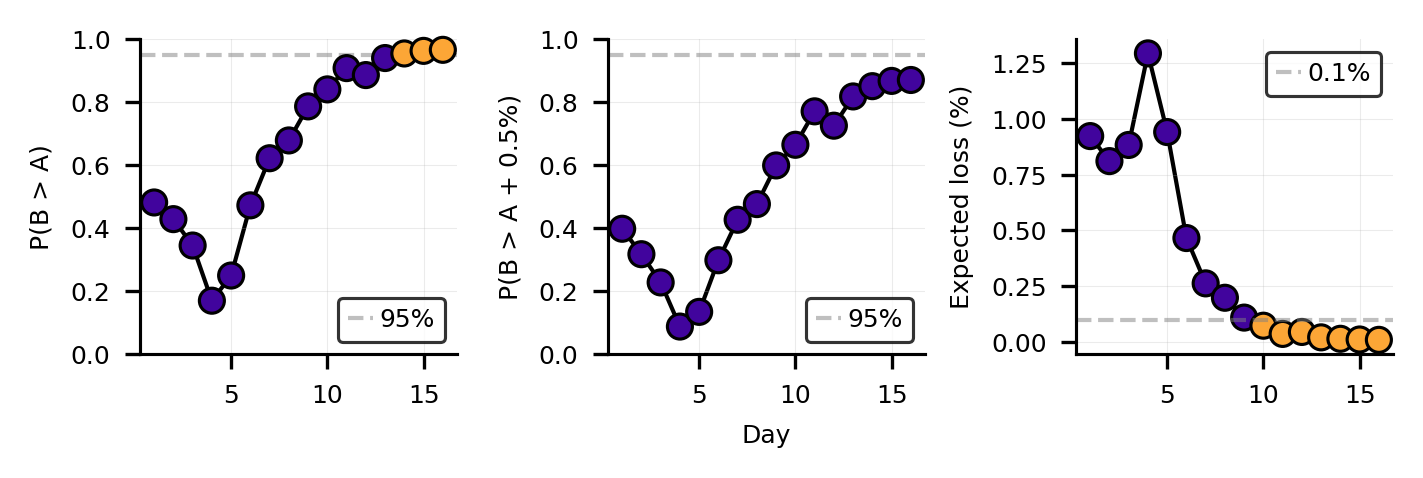

In [ ]:
# | code-fold: true
# | code-summary: Show plotting code
# | label: fig-sequential-metrics
# | fig-cap: "Bayesian metrics tracked over the course of the experiment. P(B > A) rises gradually (top), expected loss decreases (middle), and probability of exceeding the ROPE grows but does not reach 95% (bottom)."

expected_loss_decision_threshold = 0.1  # in percent

fig, axs = plt.subplots(1, 3, figsize=my.utilities.cm2inch(12, 4), sharex=True)

# P(B > A) over time
axs[0].axhline(0.95, color="gray", linestyle="--", alpha=0.5, label="95%")  # threshold
axs[0].plot(
    results_df["day"],
    results_df["prob_b_better"],
    "-",
    color="k",
    lw=1,
    zorder=-1,
)
axs[0].scatter(
    results_df["day"],
    results_df["prob_b_better"],
    color=plt.cm.plasma([0.1, 0.8])[
        (results_df["prob_b_better"] > 0.95).values.astype(int)
    ],
    edgecolor="k",
    clip_on=False,
    zorder=2,
)
axs[0].set_ylabel("P(B > A)")
axs[0].set_ylim(0, 1)
axs[0].legend(loc="lower right")
axs[0].grid(alpha=0.25, lw=0.25, fillstyle="top")

# ROPE
axs[1].plot(
    results_df["day"],
    results_df["prob_above_rope"],
    "-",
    color="k",
    lw=1,
    zorder=-1,
)
axs[1].scatter(
    results_df["day"],
    results_df["prob_above_rope"],
    color=plt.cm.plasma([0.1, 0.8])[
        (results_df["prob_above_rope"] > 0.95).values.astype(int)
    ],
    edgecolor="k",
    clip_on=False,
    zorder=2,
)
axs[1].axhline(0.95, color="gray", linestyle="--", alpha=0.5, label="95%")
axs[1].set_ylabel(f"P(B > A + {rope_width:.1%})")
axs[1].set_xlabel("Day")
axs[1].set_ylim(0, 1)
axs[1].legend(loc="lower right")
axs[1].grid(alpha=0.25, lw=0.25, fillstyle="top")

# Expected loss over time
axs[2].plot(
    results_df["day"],
    results_df["expected_loss_b"] * 100,
    "-",
    color="k",
    lw=1,
    zorder=-1,
)
axs[2].scatter(
    results_df["day"],
    results_df["expected_loss_b"] * 100,
    color=plt.cm.plasma([0.1, 0.8])[
        (
            results_df["expected_loss_b"] * 100 < expected_loss_decision_threshold
        ).values.astype(int)
    ],
    edgecolor="k",
    clip_on=False,
    zorder=2,
)
axs[2].axhline(
    expected_loss_decision_threshold,
    color="gray",
    linestyle="--",
    alpha=0.5,
    label=f"{expected_loss_decision_threshold}%",
)
axs[2].set_ylabel("Expected loss (%)")
axs[2].legend(loc="upper right")
axs[2].grid(alpha=0.25, lw=0.25, fillstyle="top")


fig.tight_layout(w_pad=1.0)
plt.show()

### Making informed decisions

So what do these metrics tell us? Let's go back to your fruit-basket dilemma.

**P(B > A)** crosses 95% on day 14 (@fig-sequential-metrics, left). You're now quite confident the new design is better. But remember our earlier warning: if you decide to stop your experiment early based on this, your probability of a "false positive" is increased.

**P(above ROPE)** never quite reaches 95% (@fig-sequential-metrics, middle). This is the sobering one. While B is *probably* better, we can't be highly confident it's *meaningfully* better by our ±0.5% threshold. The true effect is 2 percentage points—real, but modest. Sometimes the data just tell you: "Yeah, it's probably an improvement, but don't expect miracles."

**Expected loss** drops below 0.1% around day 10 (@fig-sequential-metrics, right). This is the metric I find most compelling for real decisions. It tells you: "If you ship the new design right now and you're wrong, you'll lose less than 0.1% of sign-ups per visitor." Is that worth six more days of experimentation? That depends on your traffic, your margins, and how unreasonably eager you are to ship fruit. But at least now you're making a *cost-aware* decision, not just chasing a magic number.

Three metrics, three different angles on the same experiment. Richer than a single p-value, no?

## Wrapping up

We covered the basic frequentist approach, the Bayesian Beta-Binomial model for A/B testing with binary outcomes, and three Bayesian metrics that answer questions you might actually care about: Is B better? By how much? What do I lose if I'm wrong?

The key insight here isn't that Bayesian methods are "better". I think it's more that they speak a different language. One that's often closer to the decisions you actually need to make. And while the basic model here is simple, the same logic extends to messier, more realistic scenarios: testing across user segments, modeling revenue instead of clicks, or incorporating what you learned from last quarter's experiments.
We'll be looking at this in future posts!

## Further reading

Und jedem Anfang wohnt ein Zauber inne^["In every beginning dwells a magic." – Hermann Hesse, Stufen]. In this case, I somehow thought I had an original thought with this. Well, there's *a lot* of other people that thought about this more deeply than me. These ones are particularly noteworthy:

- [Stucchio's VWO Whitepaper](https://vwo.com/downloads/VWO_SmartStats_technical_whitepaper.pdf) — expected loss as a stopping rule
- [David Robinson: "Is Bayesian A/B Testing Immune to Peeking?"](http://varianceexplained.org/r/bayesian-ab-testing/) — spoiler: it's not
- [Evan Miller's Sequential A/B Testing](https://www.evanmiller.org/sequential-ab-testing.html) — frequentist alternative
- [Spotify's Framework Comparison](https://engineering.atspotify.com/2023/03/choosing-sequential-testing-framework-comparisons-and-discussions) — industry perspective

---

*This post may evolve as I learn more. If you spot errors or have thoughts, drop me a line — I'd genuinely appreciate it.*